# Generative Adversarial Networks

[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) son una familia de arquitecturas de redes neuronales en la cual se entrenan dos modelos simultaneos de forma competitiva.

Uno de los modelos, el **generador**, se optimiza para generar muestras que se parezcan lo máximo posible a aquellas con las que se ha entrenado. Por su parte, el **discriminador** se entrena para que sea capaz de clasificar si una muestra es original o sintética, es decir, creada por el modelo **generador**.

Durante el entrenamiento de la arquitectura se establece una dinámica competitiva en la que el **generador** intenta crear las muestras sintéticas lo más perfeccionadas para evitar que el **clasificador** las identifique, y viceversa.

## Caso de estudio: generando ropa con Fashion MNIST

Vamos a crear una primera GAN para que genere ropa similar a la definida en el *dataset* **Fashion MNIST**. Cargamos el dataset de la forma habitual:

In [1]:
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

(train_imgs, train_lab), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

train_imgs = train_imgs.reshape(train_imgs.shape[0], 28, 28, 1).astype('float32')
train_imgs = (train_imgs - 127.5) / 127.5 # Normalize the images in between -1 and 1

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_set = tf.data.Dataset.from_tensor_slices(train_imgs).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### La red generadora

Vamos a crear los modelos por separado para analizar mejor qué hace cada uno. El **modelo generador** utiliza las capas `Conv2DTranspose` para realizar *upscaling*. Partiendo de una semilla aleatoria que se conecta a una capa densa, se añaden capas `Conv2DTranspose` hasta que se alcanza la resolución objetivo. En nuestro caso, la resolución objetivo es la misma que las imágenes del conjunto de datos: $28\times 28$

In [3]:
from tensorflow.keras import layers

def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Podemos usar la red para generar imágenes, aunque todavía no esté entrenada. Observa la entrada que se le pasa a la red (ruido aleatorio)

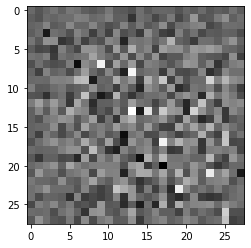

In [5]:
generator = generator_model()

noise = tf.random.normal([1, 100])
generated_img = generator(noise, training=False)

plt.imshow(generated_img[0,:,:,0], cmap='gray')

### La red discriminadora

Con respecto al modelo discriminador, se trata de una red convolucional para clasificación binaria (**real**, **sintética**). En este caso construimos una red con dos capas convolucionales acompañadas de `Dropout`. Observa que la capa de salida consta de una única neurona, pues la salida es binaria.

In [23]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128,(5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

Podemos preguntar al modelo si la imagen generada anteriormente por el modelo **generador** es real o sintética:

In [24]:
discriminator = discriminator_model()

decision_output = discriminator(generated_img, training=False)

print(decision_output)

tf.Tensor([[0.5004766]], shape=(1, 1), dtype=float32)


### Funciones de pérdida para generador y discriminador

En ambos casos estamos ante un problema de clasificación, por lo que usaremos versiones adaptadas de la entropía cruzada binaria.

In [25]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Para que el modelo discriminador funcione bien necesitamos que sea capaz de:

- clasificar correctamente las imágenes sintéticas
- clasificar correctamente las imágenes reales

Para tener en cuenta ambas clasificaciones en la función de coste hacemos una combinación lineal de ambas por separado, básicamente una suma. Para comprobar si realiza bien sus tareas, se comparan las predicciones del discriminador en imágenes reales con un **array de unos**, y las predicciones en imágenes sintéticas con un **array de ceros**.

In [26]:
def discriminator_loss(true_output, fake_output):
    true_loss = cross_entropy(tf.ones_like(true_output), true_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    tot_loss = true_loss + fake_loss
    return tot_loss

Con respecto al **modelo generador**, la función de coste tiene que cuantificar cómo de bien consigue engañar al **modelo discriminador**. Dicho de otra forma, comparamos las predicciones del discriminador en imágenes sintéticas (que deberían clasificarse como falsas o cero) con un array de unos (lo que quiere decir que el discriminador las ha clasificado como reales).

In [27]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Creamos una función para pintar imágenes sintéticas creadas por el generador:

In [28]:
def generate_and_plot_images(model, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(6,6))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()

### Entrenamiento de la GAN

Como tenemos que realizar el entrenamiento de los dos modelos de manera simultánea tenemos que usar una herramienta de *Tensorflow* que nos permite entrenar los modelos paso a paso: `GradientTape`.

El proceso en cada paso de entrenamiento es el siguiente:

1. Se usa el generador para crear imágenes sintéticas.
2. Se pide al discriminador que clasifique imágenes tanto del dataset original como las sintéticas generadas en el paso anterior.
3. Se calculan los valores de las funciones de pérdida de ambos modelos y se actualizan los pesos en función de los gradientes asociados.

In [29]:
from IPython import display

EPOCHS = 60
noise_dim = 100
num_ex_to_gen = 16

seed = tf.random.normal([num_ex_to_gen,noise_dim])

gen_optimizer = tf.keras.optimizers.Adam(1e-4)
dis_optimizer = tf.keras.optimizers.Adam(1e-4)

# Para que la función se compile en Tensorflow
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_img = generator(noise, training=True)

        true_output = discriminator(images, training=True)
        fake_output = discriminator(generated_img, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(true_output, fake_output)

    grad_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(grad_generator, generator.trainable_variables))
    dis_optimizer.apply_gradients(zip(grad_discriminator, discriminator.trainable_variables))

Definimos el bucle de entrenamiento como una función:

In [30]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for img_batch in dataset:
            train_step(img_batch)

        display.clear_output(wait=True)
        generate_and_plot_images(generator, seed)

    # Generator after final epoch
    display.clear_output(wait=True)
    generate_and_plot_images(generator, seed)

Ahora basta con ejecutar la función de entrenamiento para que ambos modelos se optimicen simultáneamente y de manera competitiva.

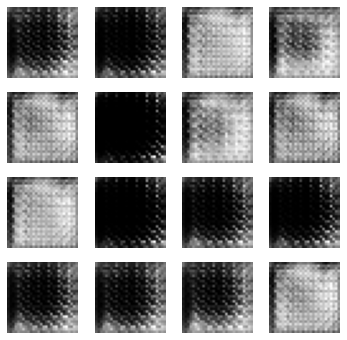

KeyboardInterrupt: 

In [32]:
with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    train(train_set, EPOCHS)

Una vez entrenada la GAN, podemos usar el modelo generador para crear imágenes sintéticas de la misma forma que hemos hecho antes:

In [ ]:
generate_and_plot_images(generator, tf.random.normal([12, 100]))

---

Creado por **Raúl Lara Cabrera** (raul.lara@upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">